* json 포맷 활용

In [1]:
# about json
import json
a = {'value1':5, 'value2':7, 'seq':[1,2,3,4,5]}

filename = 'results/test.json'
with open(filename, 'w') as f:
    json.dump(a,f)

with open(filename, 'r') as f:
    a = json.load(f)
    print(a)

# file name setting
import hashlib
setting = {'para1':5, 'para2':7, 'para3':[1,2,3,4,5], 'exp_name':'exp1'}
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
print(hash_key)

exp_name = setting['exp_name']
filename = 'results/{}-{}.json'.format(exp_name, hash_key)
print(filename)

{'value1': 5, 'value2': 7, 'seq': [1, 2, 3, 4, 5]}
7c62c1
results/exp1-7c62c1.json


In [2]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

# Data Preparation

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


# Model Architecture

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

# Experiment Preparation

In [6]:
from utils.experiment import *

In [7]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)
    print('Test Acc: {}'.format(test_acc))    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

## Manage Experiment Results

In [8]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) # 두 파일 합치기
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Experiment 1

In [10]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=500, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)
Epoch 0, Acc(train/val): 37.56/41.92, Loss(train/val) 2.54/1.74. Took 3.12 sec
Epoch 1, Acc(train/val): 45.78/35.14, Loss(train/val) 1.58/2.02. Took 2.98 sec
Epoch 2, Acc(train/val): 48.45/39.65, Loss(train/val) 1.49/1.84. Took 2.97 sec
Epoch 3, Acc(train/val): 50.67/44.01, Loss(train/val) 1.44/1.75. Took 2.94 sec
Epoch 4, Acc(train/val): 52.81/39.56, Loss(train/val) 1.38/2.23. Took 2.98 sec
Epoch 5, Acc(train/val): 54.91/43.69, Loss(train/val) 1.33/1.83. Took 2.97 sec
Epoch 6, Acc(train/val): 56.85/41.29, Loss(train/val) 1.28/1.96. Took 3.05 sec
Epoch 7, Acc(train/val): 58.52/40.05, Loss(train/val) 1.23/2.16. Took 2.96 sec
Epoch 8, Acc(train/val): 60.37/49.00, Loss(train/val) 1.19/1.57. Took 2.96 sec
Epoch 9, Acc(train/val): 61.95/49.25, Loss(train/v

In [15]:
!ls results
!cat results/exp1_n_layer_hid_dim-41b634.json

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json  test.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json


{"train_losses": [1.779500877021984, 1.5117500504111028, 1.4082096351939402, 1.3273928901951784, 1.2522195471320183, 1.1942882067078997, 1.1348167916012417, 1.0842200005130402, 1.0363014211320574, 0.9874690919165399], "val_losses": [1.6555643200874328, 2.091448163986206, 1.6091444373130799, 1.4475848197937011, 1.4746812343597413, 1.4049250721931457, 1.4474509358406067, 1.4571048855781554, 1.48341646194458, 1.6465782880783082], "train_accs": [36.705, 45.8225, 49.535, 52.525, 55.27, 57.225, 59.415, 61.1525, 62.9875, 64.8725], "val_accs": [40.54, 42.79, 43.47, 47.41, 48.09, 50.62, 50.23, 50.13, 49.94, 47.29], "train_acc": 64.8725, "val_acc": 47.29, "test_acc": 46.95, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l2": 1e-05, "use_xavier": true, "optim": "RMSprop", "lr": 0.0015, "train_batch_size": 256, "n_layer": 3}

In [24]:
load_exp_result('exp1_n')

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[1.789023368221939, 1.5291730894404612, 1.4180...","[1.8200905561447143, 1.6648520588874818, 1.636...","[37.0925, 45.765, 49.625, 52.9475, 55.2175, 57...","[36.35, 43.38, 43.42, 47.46, 44.99, 49.75, 45....",66.0725,50.87,50.76,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
1,"[1.8374172714865131, 1.5249628618264655, 1.414...","[1.8087824940681458, 1.6433112978935243, 1.532...","[35.4225, 45.21, 48.98, 52.29, 54.73, 57.725, ...","[37.57, 42.25, 45.72, 40.96, 45.21, 48.79, 45....",65.0700,52.56,52.83,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
2,"[2.5440616440621153, 1.58178898331466, 1.49302...","[1.7401856780052185, 2.0173448801040648, 1.842...","[37.565, 45.785, 48.4525, 50.6675, 52.81, 54.9...","[41.92, 35.14, 39.65, 44.01, 39.56, 43.69, 41....",61.9450,49.25,48.42,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
3,"[1.779500877021984, 1.5117500504111028, 1.4082...","[1.6555643200874328, 2.091448163986206, 1.6091...","[36.705, 45.8225, 49.535, 52.525, 55.27, 57.22...","[40.54, 42.79, 43.47, 47.41, 48.09, 50.62, 50....",64.8725,47.29,46.95,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
4,"[1.7609814853425239, 1.5208174962147025, 1.419...","[1.7366371989250182, 1.5260657906532287, 1.610...","[37.6425, 46.005, 49.61, 52.7075, 55.055, 57.0...","[39.86, 46.62, 44.57, 47.96, 48.09, 46.3, 39.6...",64.4500,49.37,48.86,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
5,"[2.2123319457291037, 1.5431043699288824, 1.455...","[1.8916689157485962, 2.09196959733963, 1.67875...","[38.4925, 46.3325, 49.685, 51.595, 53.8375, 55...","[38.51, 36.44, 42.24, 40.11, 44.85, 41.39, 48....",62.1725,49.10,50.20,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

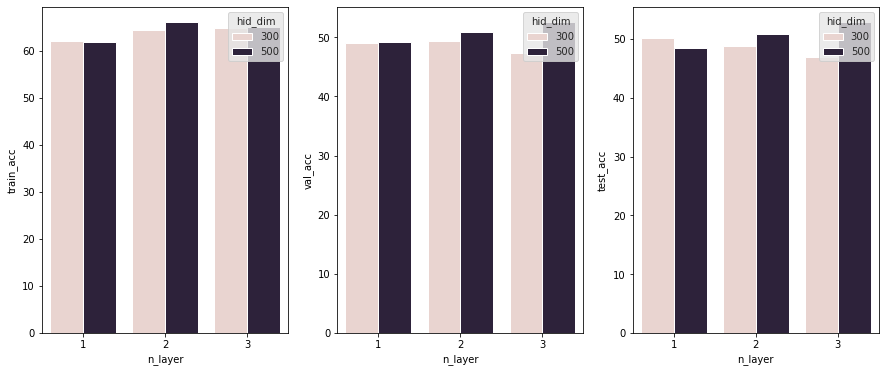

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1') ## 저장한 데이터 불러오기

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

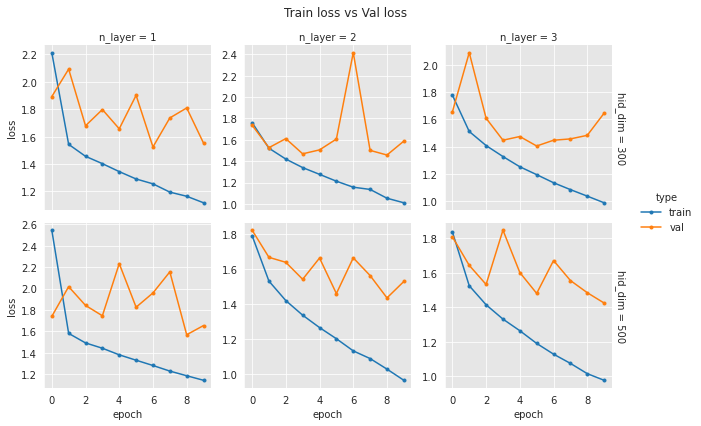

In [12]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

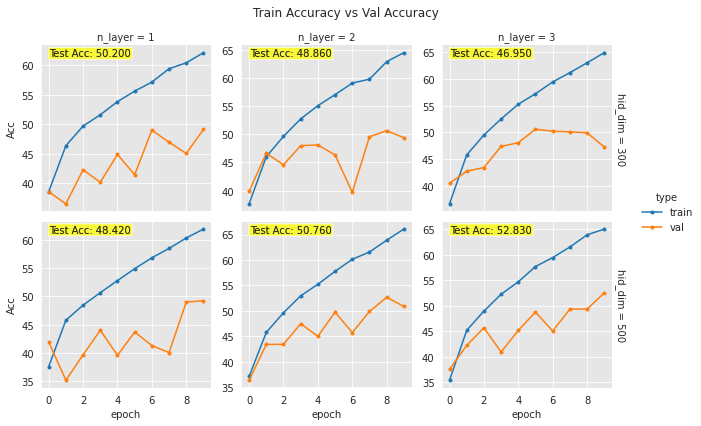

In [13]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1_n')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

# Experiment 2

In [17]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_dropout"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 512
args.act = 'relu'
args.n_layer = 3

# ====== Regularization ======= #
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.0001, 0.001, 0.01]
list_var2 = [0, 0.1, 0.3, 0.5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_lr_dropout', in_dim=3072, out_dim=10, hid_dim=512, act='relu', n_layer=3, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', epoch=10, train_batch_size=256, test_batch_size=1024, lr=0.0001, dropout=0)
Epoch 0, Acc(train/val): 41.94/45.05, Loss(train/val) 1.64/1.56. Took 3.06 sec
Epoch 1, Acc(train/val): 51.92/48.78, Loss(train/val) 1.38/1.45. Took 3.01 sec
Epoch 2, Acc(train/val): 56.40/49.37, Loss(train/val) 1.25/1.43. Took 3.00 sec
Epoch 3, Acc(train/val): 60.60/47.45, Loss(train/val) 1.15/1.49. Took 3.03 sec
Epoch 4, Acc(train/val): 64.27/49.89, Loss(train/val) 1.05/1.43. Took 3.02 sec
Epoch 5, Acc(train/val): 67.48/50.19, Loss(train/val) 0.96/1.42. Took 2.96 sec
Epoch 6, Acc(train/val): 70.79/49.50, Loss(train/val) 0.88/1.48. Took 3.02 sec
Epoch 7, Acc(train/val): 73.93/47.91, Loss(train/val) 0.80/1.60. Took 3.01 sec
Epoch 8, Acc(train/val): 76.60/48.64, Loss(train/val) 0.72/1.56. Took 3.03 sec
Epoch 9, Acc(train/val): 79.30/49.83, Loss(train/val) 0.6

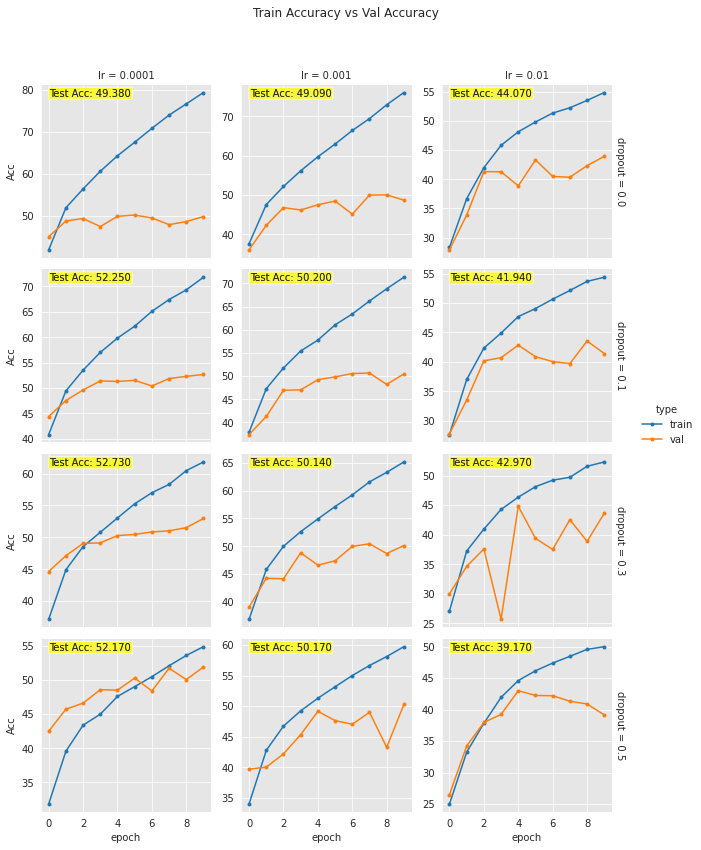

In [23]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp1_lr')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)